
# Creation of a quantization, use and evaluation pipeline, featuring LLaMA2 7B model and Perplexity

In this notebook, we evaluate the impact quantization has in a common use LLM model, in our case LLaMA 2 7B, evaluating it in a text generation task. Our pipeline is defined as follows:
- Quantize the model using **BitsAndBytes**, **GPTQ** and **HQQ**.
- Compare the performance of our models in terms of perplexity, inference speed and emissions. 

### Goals
1. Analize the impact quantization has on performance.
2. Compare the efficiency and perplexity of the quantized models with the not-quantized model.


## Perplexity

### Introduction to Perplexity

In natural language processing (NLP), **perplexity** is a widely used metric to evaluate the performance of language models. It provides a quantitative measure of how well a model predicts a sequence of words. Conceptually, perplexity can be understood as the **degree of uncertainty** a model has when generating or evaluating text: the lower the perplexity, the more confident and accurate the model is in its predictions.

Formally, given a sequence of $N$ words $w_1, w_2, ..., w_N$, and a probabilistic model that assigns a likelihood $P(w_i | w_1, ..., w_{i-1})$ to each word based on its context, the perplexity is defined as:

$$
\text{Perplexity} = \exp\left(-\frac{1}{N} \sum_{i=1}^{N} \log P(w_i | w_1, ..., w_{i-1})\right)
$$

This metric essentially calculates the inverse probability of the test set, normalized by the number of words. It tells us, on average, how many different options the model is "confused" between when predicting the next token.

### Why Use Perplexity?

- It’s **interpretable**: a perplexity of 10 means that the model is, on average, as uncertain as choosing among 10 possible words.
- It’s **comparable**: useful when evaluating multiple models on the same dataset.
- It’s **sensitive to improvements** in prediction quality, especially when optimizing language models.

### Limitations of Perplexity

Despite its popularity, perplexity has some limitations:

- It is **unbounded above**—there is no theoretical maximum value.
- It is **sensitive to the tokenization scheme** and vocabulary size.
- It doesn’t always correlate perfectly with downstream task performance (e.g., classification accuracy).



In this notebook, we use **perplexity as the main performance indicator** when comparing different versions of our language model (e.g., original vs. quantized). To provide a more comprehensive view, we also consider each model’s **carbon emissions**, and later introduce a new metric that combines both aspects—performance and sustainability—into a single interpretable score.

## Hardware and software

### Hardware
- CPU: Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
- RAM: 985 GB
- GPU: NVIDIA A100-PCIE-40GB
### Software
For this project, we used the following python libraries: torch, transformers, time, datasets and each quantization method library, among others. Of course, all the libraries that these libraries have dependencies with are needed too.
We also used some other libraries or tools that help to evaluate the results. For example, the library CodeCarbon was used to collect emissions data, and the Weights and Biases (Wandb) platform was used to collect and visualize metrics. 


## Project pipeline

### 1. Base model preparation
The base model used is **LLaMA 2 (7B)**. We loaded it using the Transformers library from HugginFace.

### 2. Quantization 
Quantization was performed using **BitsAndBytes**, **GPTQ** and **HQQ**. This first quantization method offers 2 quantization options: **8 bits** and **4 bits**, while the two other methods also offer **3 bits** quantization.

### 3. Evaluation
These models were evaluated and compared in terms of: **perplexity**, **inference speed** and **emissions**. The dataset used was the **Wikitext2** dataset.


## Results

### Perplexity results
We now show the results obtained for perplexity with each of the three models:

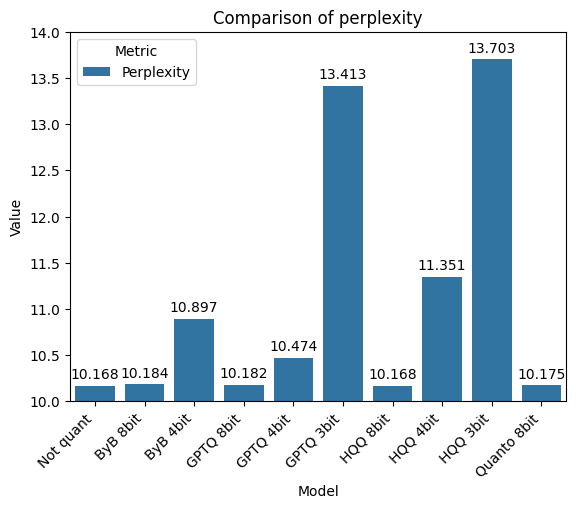

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit'],
    'Perplexity': [10.168, 10.184, 10.897, 10.182, 10.474, 13.413, 10.168, 11.351, 13.703, 10.175]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)
plt.title('Comparison of perplexity')
plt.ylim(10.0, 14.0)
plt.xticks(rotation=45, ha='right')
plt.show()


We observe how the best perplexity is achieved by the not quantized model, followed very closely by the three 8bit models. In fact, the 8bit HQQ quantized model achieves the same perplexity than the not quantized model. Regarding the 4bit models, they don't perform as good but they are not too far away from the others, specially the 4bit GPTQ model. Lastly, the 3bit models are the worse ones, obtainen substantially higher perplexities. 

### Memory use results

Measuring memeory needs is not an easy task. We decided to check the maximum memory need while inference (in GPU). Note that this measure tends to be higher due to needs associated with inference, specially when using batches.

Now we show the maximum memory needed for inference for each model and inference configuration:

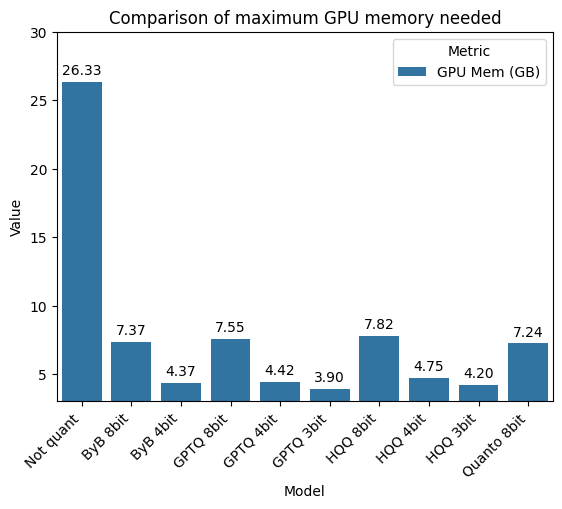

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit'],
    'GPU Mem (GB)': [26.33, 7.37, 4.37, 7.55, 4.42, 3.90, 7.82, 4.75, 4.20, 7.24]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of maximum GPU memory needed')
plt.ylim(3.0, 30.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how all quantized models perform better than the base model, as expected. It also seems like the lower the bit count, the lower memory requirements.

### Inference speed results

In this section we show the results obtained for inference time and quantization time:  

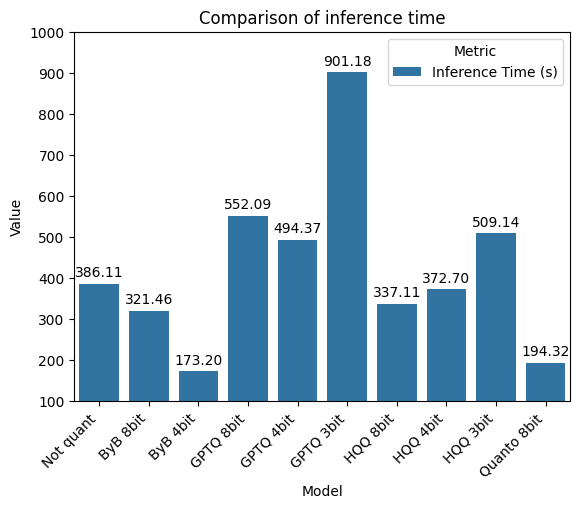

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit'],
    'Inference Time (s)': [386.11, 321.46, 173.20, 552.09, 494.37, 901.18, 337.11, 372.70, 509.14, 194.32]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of inference time')
plt.ylim(100.0, 1000.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how GPTQ obtains the worse results by far. Regarding HQQ, it looks like the lower the bit count the slower is the model, contrary to what would be expected. BitsAndBytes seems to obtain the good results, with both models being faster than the base model and with the 4bit model being the fastest one. Finally, Quanto seems to perform really good. Its 8bit model performs closely to the fastest model, with a higher bit count. However, since we don't have results for the 4bit configuration of Quanto because library limitations, we can't obtain a full comparison.

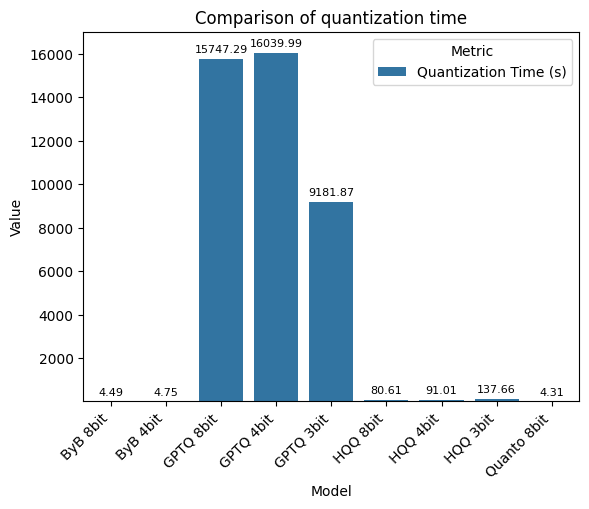

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit'],
    'Quantization Time (s)': [4.49, 4.75, 15747.29, 16039.99, 9181.87, 80.61, 91.01, 137.66, 4.31]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3, fontsize=8)
plt.title('Comparison of quantization time')
plt.ylim(3.0, 17000.0)
plt.xticks(rotation=45, ha='right')
plt.show()

Wee see how BitsAndBytes and Quanto are, by far, the fastest methods to quantize, while GPTQ is the slowest by a huge margin. HQQ obtains acceptable results. 

Regarding the difference between bits, with BitsAndBytes we don't see a significant difference, and with GPTQ the 3bit model is noticeably faster. Finally, with HQQ it seems like the lower the bit count, the slower is the quantization.

### Emissions results

The emissions are a little challenging to measure and compare. This is because we need to decide if we take into account the emissions generated during the quantization of the models. Our approach will show the resuts obtained for evaluation separated from the emissions for the quantization process, but will take them into consideration when comparing. We will measure the emissions of CO<sub>2</sub> in kilograms of CO<sub>2</sub>-equivalents \[CO<sub>2</sub>eq\]

The emissions generated by the evaluation process and the quantization were:


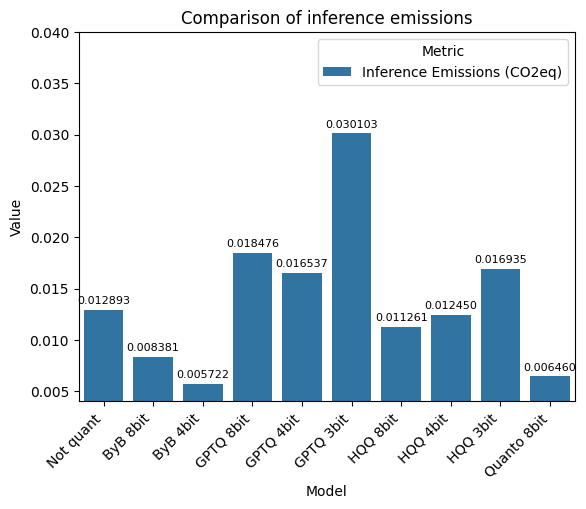

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit'],
    'Inference Emissions (CO2eq)': [0.012893, 0.008381, 0.005722, 0.018476, 0.016537, 0.030103, 0.011261, 0.012450, 0.016935, 0.006460]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3, fontsize=8)
plt.title('Comparison of inference emissions')
plt.ylim(0.004, 0.04)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how, following the same trend shown in speed results, GPTQ obtains the worse results by far. Regarding HQQ, it looks like the lower the bit count the more emissions, contrary to what would be expected. BitsAndBytes seems to obtain the good results, similar with the inference speed ones, with both models having less emissions than the base model and with the 4bit model being the lowest one. Finally, Quanto seems to perform really good, like we saw with inference time results.

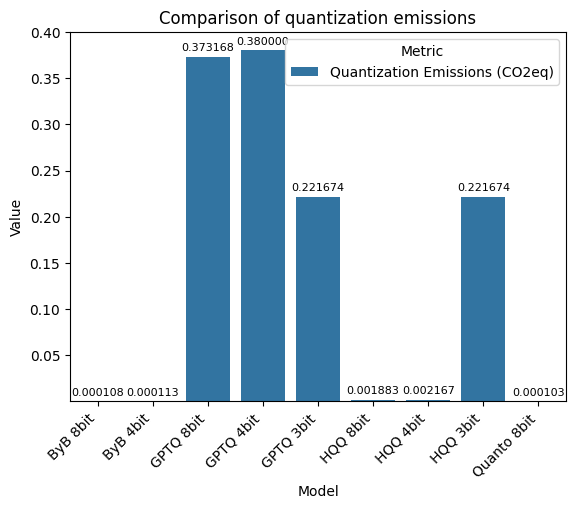

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit'],
    'Quantization Emissions (CO2eq)': [0.000108, 0.000113, 0.373168, 0.380000, 0.221674, 0.001883, 0.002167, 0.221674, 0.000103]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3, fontsize=8)
plt.title('Comparison of quantization emissions')
plt.ylim(0.0001, 0.4)
plt.xticks(rotation=45, ha='right')
plt.show()

Again, quantization emissions results follow the same trend seen before with quantization time results. We see how BitsAndBytes and Quanto are, by far, the best methods to quantize regarding emissions, while GPTQ is the worse one by a huge margin. HQQ obtains acceptable results, specially with the 8 and 4 bits variants

Regarding the difference between bits, with BitsAndBytes we don't see a significant difference, and with GPTQ the 3bit model is noticeably more efficient. Finally, with HQQ it seems like the lower the bit count, the more emissions.

## All together

We now show these results together to have a better view of how each model performs.

Firstly, we show this radar chart with the 8 bit models:

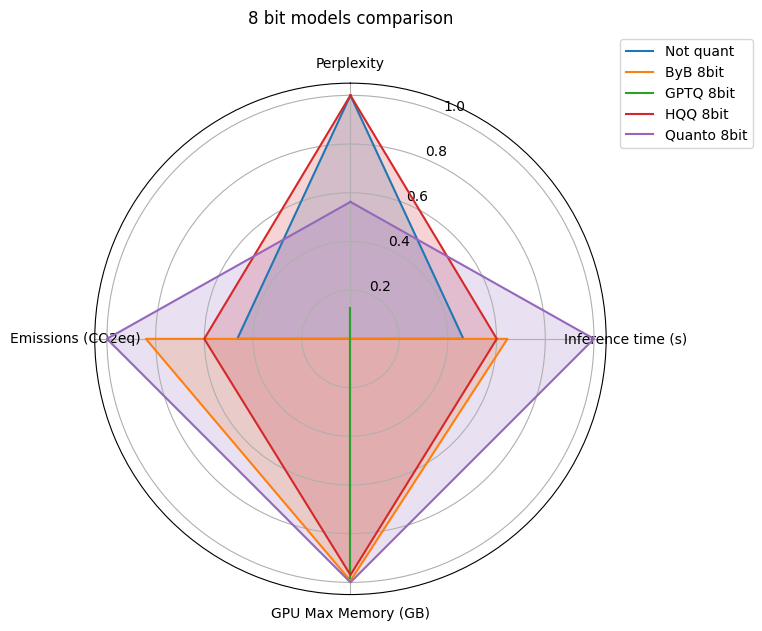

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'GPTQ 8bit', 'HQQ 8bit', 'Quanto 8bit'],
    'Perplexity': [10.168, 10.184, 10.182, 10.168, 10.175],
    'Inference time (s)': [386.11, 321.46, 552.09, 337.11, 194.32],
    'GPU Max Memory (GB)': [26.33, 7.37, 7.55, 7.82, 7.24],
    'Emissions (CO2eq)': [0.012893, 0.008381, 0.018476, 0.011261, 0.006460]
})

metrics = ['Perplexity', 'Inference time (s)', 'GPU Max Memory (GB)', 'Emissions (CO2eq)']

# Normalization
for col in metrics:
    df[col + '_norm'] = 1 - (df[col] - df[col].min()) / (df[col].max() - df[col].min())

labels = metrics 
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df.iterrows():
    valores = [row[m + '_norm'] for m in metrics]
    valores += valores[:1] 
    ax.plot(angles, valores, label=row['Model'])
    ax.fill(angles, valores, alpha=0.2)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('8 bit models comparison', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()



Now we compare th 4bit models the same way:

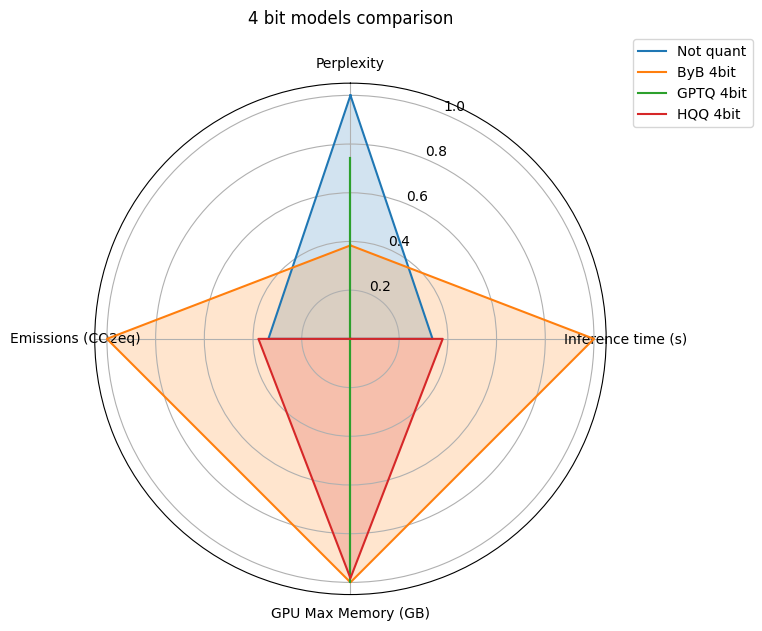

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 4bit', 'GPTQ 4bit', 'HQQ 4bit'],
    'Perplexity': [10.168, 10.897, 10.474, 11.351],
    'Inference time (s)': [386.11, 173.20, 494.37, 372.70],
    'GPU Max Memory (GB)': [26.33, 4.37, 4.42, 4.75],
    'Emissions (CO2eq)': [0.012893, 0.005722, 0.016537, 0.012450]
})

metrics = ['Perplexity', 'Inference time (s)', 'GPU Max Memory (GB)', 'Emissions (CO2eq)']

# Normalization
for col in metrics:
    df[col + '_norm'] = 1 - (df[col] - df[col].min()) / (df[col].max() - df[col].min())

labels = metrics 
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df.iterrows():
    valores = [row[m + '_norm'] for m in metrics]
    valores += valores[:1] 
    ax.plot(angles, valores, label=row['Model'])
    ax.fill(angles, valores, alpha=0.2)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('4 bit models comparison', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()



Lastly, we compare the two 3 bit models:

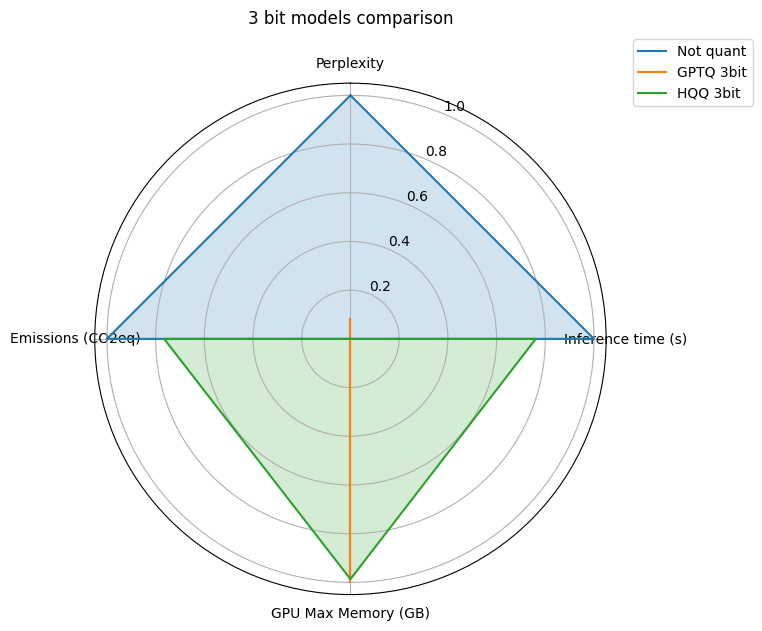

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'GPTQ 3bit', 'HQQ 3bit'],
    'Perplexity': [10.168, 13.413, 13.703],
    'Inference time (s)': [386.11, 901.18, 509.14],
    'GPU Max Memory (GB)': [26.33, 3.90, 4.20],
    'Emissions (CO2eq)': [0.012893, 0.030103, 0.016935]
})

metrics = ['Perplexity', 'Inference time (s)', 'GPU Max Memory (GB)', 'Emissions (CO2eq)']

# Normalization
for col in metrics:
    df[col + '_norm'] = 1 - (df[col] - df[col].min()) / (df[col].max() - df[col].min())

labels = metrics 
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

for i, row in df.iterrows():
    valores = [row[m + '_norm'] for m in metrics]
    valores += valores[:1] 
    ax.plot(angles, valores, label=row['Model'])
    ax.fill(angles, valores, alpha=0.2)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
ax.set_title('3 bit models comparison', y=1.1)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

## A New Metric: Balancing Model Performance and Sustainability

As part of our study, we aim to evaluate models not only by their predictive quality, but also by their environmental impact. To do this, we introduce a new metric that jointly captures **model performance** (via perplexity) and **carbon emissions** (measured in CO₂eq), enabling a more holistic comparison across different model configurations.

### Motivation

Traditionally, lower perplexity is used as a signal of better model performance. On the other hand, a lower carbon footprint is preferable from a sustainability standpoint. However, these two objectives often trade off against each other—improving performance can come at the cost of significantly higher emissions.  

To visualize this, we include the following scatter plot, where each point represents a different model run, with **perplexity on the x-axis** and **CO₂ emissions on the y-axis**. The ideal region is at the **bottom-left corner**, where both perplexity and emissions are low.



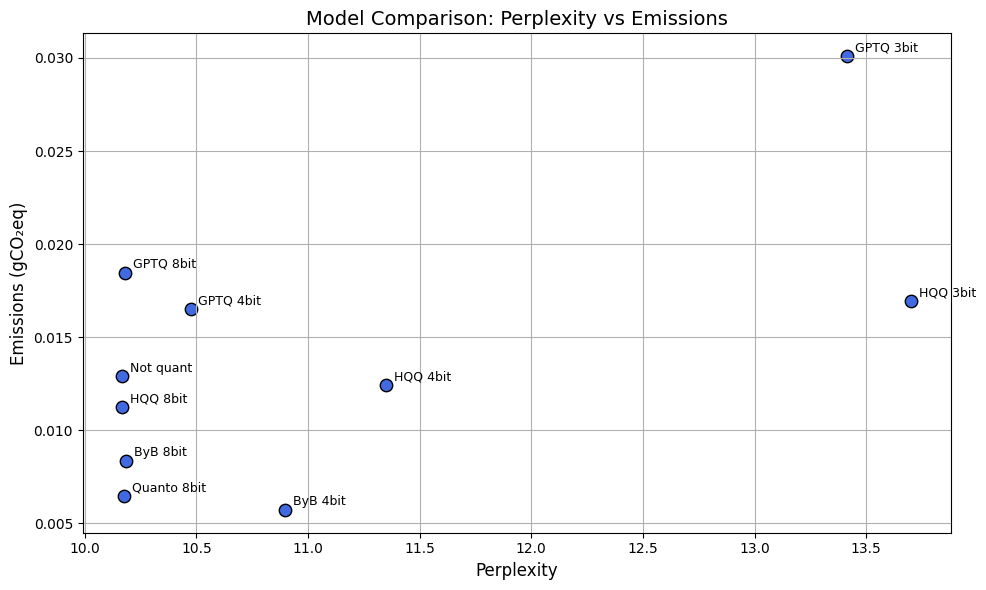

In [1]:
import matplotlib.pyplot as plt
import numpy as np

model_names = ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit']
perplexities = np.array([10.168, 10.184, 10.897, 10.182, 10.474, 13.413, 10.168, 11.351, 13.703, 10.175])
co2_emissions = np.array([0.012893, 0.008381, 0.005722, 0.018476, 0.016537, 0.030103, 0.011261, 0.012450, 0.016935, 0.006460]) 

plt.figure(figsize=(10, 6))
plt.scatter(perplexities, co2_emissions, color='royalblue', s=80, edgecolor='black')

# Desplazamientos proporcionales al rango de datos
x_offset = (max(perplexities) - min(perplexities)) * 0.01
y_offset = (max(co2_emissions) - min(co2_emissions)) * 0.01

for i, name in enumerate(model_names):
    plt.annotate(name,
                 (perplexities[i] + x_offset, co2_emissions[i] + y_offset),
                 fontsize=9)

plt.xlabel("Perplexity", fontsize=12)
plt.ylabel("Emissions (gCO₂eq)", fontsize=12)
plt.title("Model Comparison: Perplexity vs Emissions", fontsize=14)
plt.grid(True)

plt.tight_layout()
plt.show()




This tension motivates the need for a **single metric** that reflects both aspects simultaneously.

### Definition of the Metric

Let $p_i$ be the perplexity and $c_i$ the carbon emissions of model $i$. We define a normalized perplexity score via the **softmax** function across all models:

$$
\hat{p}_i = \frac{e^{p_i}}{\sum_j e^{p_j}}
$$

This softmax transformation ensures that higher perplexity values are penalized exponentially, while preserving comparability within the current experiment.

We then define our **combined score** as:

$$
\text{Score}_i = \hat{p}_i \times c_i
$$

This metric directly couples performance and sustainability. Lower scores indicate better trade-offs—either due to excellent performance, low emissions, or both.

### Interpretation

- A **low score** means the model has both low perplexity (relative to others) and low emissions.
- A **high score** reflects either poor performance, high emissions, or both.
- The metric does **not require knowing the absolute range** of perplexity or CO₂ values, and it adapts to the dynamic scale of any given experiment.

This approach provides a practical and interpretable way to assess models beyond accuracy alone.



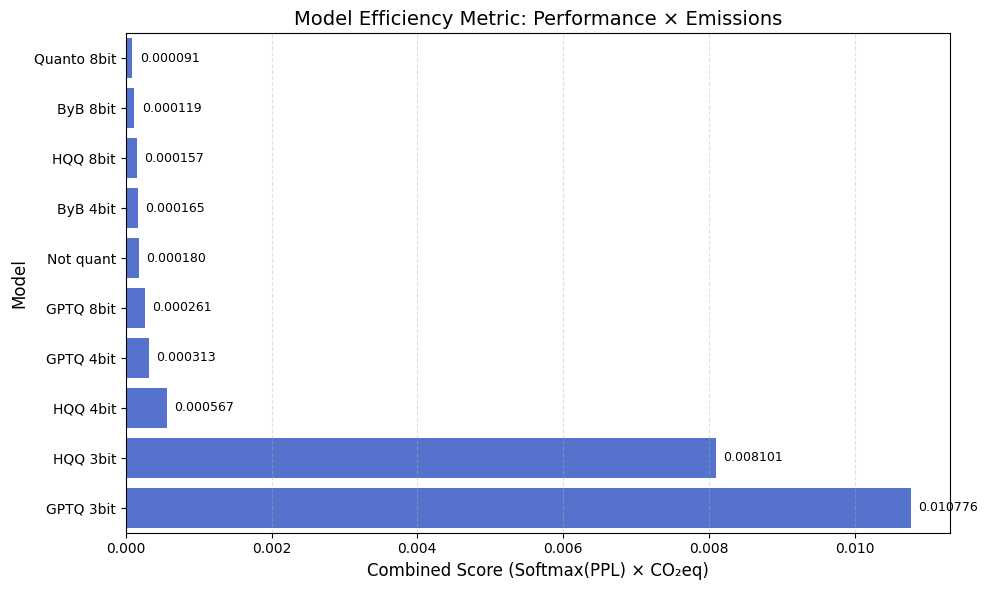

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
model_names = ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit']
perplexities = np.array([10.168, 10.184, 10.897, 10.182, 10.474, 13.413, 10.168, 11.351, 13.703, 10.175])
co2_emissions = np.array([0.012893, 0.008381, 0.005722, 0.018476, 0.016537, 0.030103, 0.011261, 0.012450, 0.016935, 0.006460])

# Softmax of perplexity
exp_perplexities = np.exp(perplexities)
softmax_perplexities = exp_perplexities / np.sum(exp_perplexities)

# Combined score
combined_score = softmax_perplexities * co2_emissions

# Sort for better visualization
sorted_indices = np.argsort(combined_score)
model_names_sorted = [model_names[i] for i in sorted_indices]
combined_score_sorted = combined_score[sorted_indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=combined_score_sorted, y=model_names_sorted, color='royalblue')
plt.xlabel("Combined Score (Softmax(PPL) × CO₂eq)", fontsize=12)
plt.ylabel("Model", fontsize=12)
plt.title("Model Efficiency Metric: Performance × Emissions", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Annotate values
for i, v in enumerate(combined_score_sorted):
    plt.text(v + 0.0001, i, f"{v:.6f}", va='center', fontsize=9)

plt.tight_layout()
plt.show()



We see how, with this new metric, we are able to define which models are the best. Surprisingly, both 3bit models are the worse ones, while the 8bit versions of Quanto, BitsAndBytes and HQQ are the best options. The 4bit option of BitsAndBytes also gets a good result. Lastly, the base model obtains a good result, being in fourth place. It seems like the good perplexity and the fact that some quantized models do not perform better in terms of speed and emissions help this model.


## Conclusions

Results show that:

1. Quantization does in fact increment perplexity, and the lower the bit count, the higher this it is. However, the drop with the 8 bit variant of the methods used is not as significant.
2. Quantized models are noticeably better in terms of memory usage compared to the base model.
3. Quantized models with **BitsAndBytes** and **Quanto** are faster than the base model. However, the rest of quantization methods do not improve inference speed. More testing and understanding of each quantization method is needed to extract clear conclusions.
4. We define a new metric that relate perplexity and emissions, which helps to decide which model performs best. 

